# 4. Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from skopt import BayesSearchCV

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ChangedBehaviorWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning,
                                          ChangedBehaviorWarning,
                                          DeprecationWarning,
                                          RuntimeWarning))

/home/rei/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set up directories
SEED = 149028763
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'processed_data', 'features')
dir_out = os.path.join(parent_dir, 'analyses')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y,
                                                    random_state=SEED)

Loaded 105822 samples with 4456 features


## Hyperparameter Tuning

Bayesian search on `LogisticRegression` with `BayesSearchCV`

In [5]:
# Set up classifier pipeline
estimator = LogisticRegression(solver='liblinear', penalty='l1',
                               max_iter=2000, random_state=SEED)

pipe = Pipeline([('scaler', MaxAbsScaler()), ('clf', estimator)])

In [6]:
# Callback function
def status_print(optim_result):
    """Status callback durring Bayesian hyperparameter search"""
    
    # Get current parameters and the best parameters 
    n = len(pd.DataFrame(opt.cv_results_))
    print('Iteration %i, best %s score: %.6f'\
          % (n, scoring, opt.best_score_))

In [7]:
# Perform hyperparameter optimization
param_space = {'clf__C': (1, 5, 'uniform')}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = 'neg_log_loss'

opt = BayesSearchCV(pipe, param_space,cv=cv, scoring=scoring, n_iter=20,
                    n_jobs=5, verbose=0, random_state=SEED)

cv_results = opt.fit(X_train, y_train, callback=status_print)

Iteration 1, best neg_log_loss score: -0.112972
Iteration 2, best neg_log_loss score: -0.109703
Iteration 3, best neg_log_loss score: -0.109701
Iteration 4, best neg_log_loss score: -0.109701
Iteration 5, best neg_log_loss score: -0.109701
Iteration 6, best neg_log_loss score: -0.109701
Iteration 7, best neg_log_loss score: -0.109701
Iteration 8, best neg_log_loss score: -0.109701
Iteration 9, best neg_log_loss score: -0.109701
Iteration 10, best neg_log_loss score: -0.109701
Iteration 11, best neg_log_loss score: -0.109701


/home/rei/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12, best neg_log_loss score: -0.109701
Iteration 13, best neg_log_loss score: -0.109701
Iteration 14, best neg_log_loss score: -0.109701


/home/rei/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 15, best neg_log_loss score: -0.109701


/home/rei/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16, best neg_log_loss score: -0.109701


/home/rei/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17, best neg_log_loss score: -0.109701
Iteration 18, best neg_log_loss score: -0.109701
Iteration 19, best neg_log_loss score: -0.109701
Iteration 20, best neg_log_loss score: -0.109701


In [8]:
# Set best estimator as classifier
opt.best_params_

print('Test %s score: %.4f' % (scoring, opt.score(X_test, y_test)))
pipe = opt.best_estimator_

{'clf__C': 2.6374624571220413}

Test neg_log_loss score: -0.0988


              precision    recall  f1-score   support

           0     0.9783    0.9981    0.9881     19657
           1     0.9666    0.7109    0.8193      1508

    accuracy                         0.9777     21165
   macro avg     0.9724    0.8545    0.9037     21165
weighted avg     0.9774    0.9777    0.9761     21165



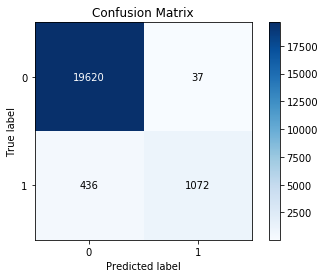

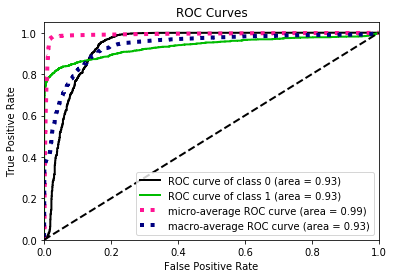

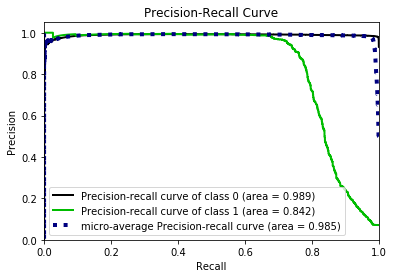

In [9]:
# Evaluate model

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=4))

# Plot metrics
_ = plot_confusion_matrix(y_test, y_pred)
_ = plot_roc(y_test, y_proba)
_ = plot_precision_recall(y_test, y_proba)
_ = plt.show()

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9746    0.9620    0.9683     36476
           1     0.5716    0.6686    0.6163      2764

    accuracy                         0.9414     39240
   macro avg     0.7731    0.8153    0.7923     39240
weighted avg     0.9462    0.9414    0.9435     39240



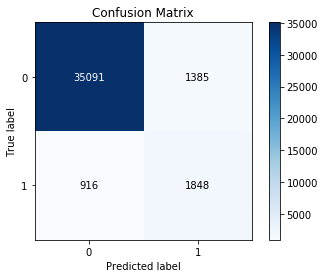

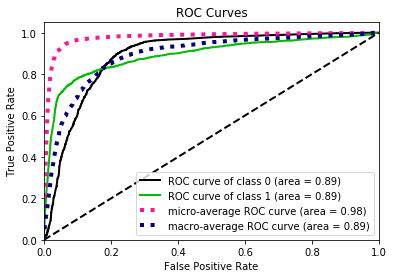

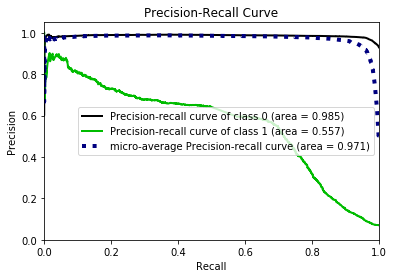

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9738    0.9747    0.9742     49151
           1     0.6491    0.6409    0.6450      3590

    accuracy                         0.9520     52741
   macro avg     0.8114    0.8078    0.8096     52741
weighted avg     0.9517    0.9520    0.9518     52741



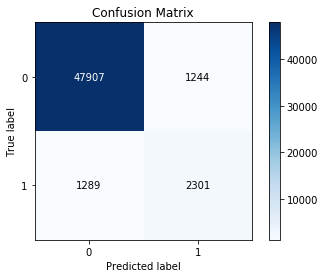

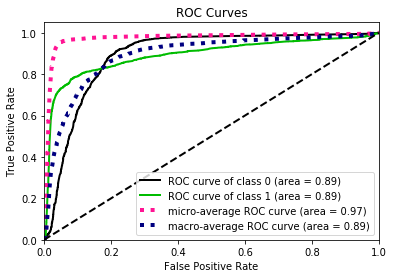

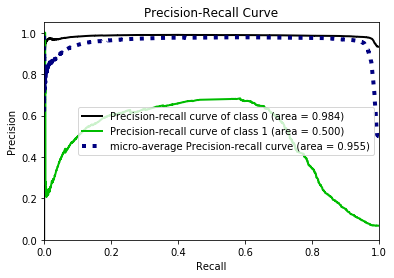

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9762    0.9783    0.9773     12654
           1     0.7636    0.7456    0.7545      1187

    accuracy                         0.9584     13841
   macro avg     0.8699    0.8620    0.8659     13841
weighted avg     0.9580    0.9584    0.9582     13841



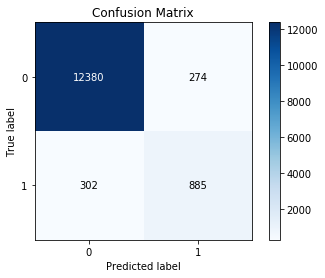

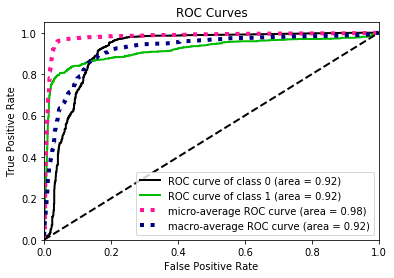

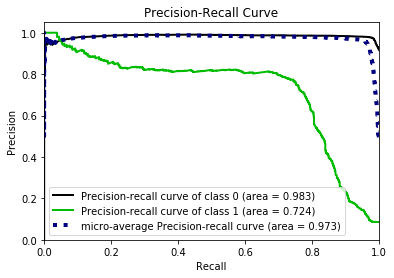

<hr></hr>

In [10]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train pipeline
    _ = pipe.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plot_precision_recall(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))

In [11]:
# Refit model with the whole dataset
_ = pipe.fit(X, y)

# Dump model as pickle
_ = joblib.dump(pipe, 'best_model.pkl')

## Examine feature importances from coefficients

In [5]:
# Get feature names: Pfam set
feat_names = np.array(joblib.load('pfam.pkl')[1])
feat_names

array(['PF00001', 'PF00002', 'PF00004', ..., 'PF18829', 'PF18837',
       'PF18868'], dtype='<U7')

In [6]:
# Get model coefficients
pipe = joblib.load('best_model.pkl')
coefs = pipe['clf'].coef_[0]

In [7]:
sort_index = coefs.argsort()[::-1] # descending
sorted_coefs = coefs[sort_index]
sorted_feats = feat_names[sort_index]

df = pd.DataFrame([sorted_feats, sorted_coefs], index=['Feature_name', 'Coefficient']).T
df.head(10)
df.tail(10)

# Save list of domains along with their coefficients
f_out = os.path.join(dir_out, 'model_coefficients')
df.to_csv(f_out, sep='\t', index=None)

,Feature_name,Coefficient
0,PF07679,55.4389
1,PF05473,32.9098
2,PF13465,30.9692
3,PF13912,28.6351
4,PF17820,23.5988
5,PF00041,19.1841
6,PF13921,18.724
7,PF16620,16.8253
8,PF07705,14.6739
9,PF00550,14.1817


,Feature_name,Coefficient
4446,PF00578,-13.3175
4447,PF00102,-13.512
4448,PF04851,-16.9627
4449,PF13894,-17.1613
4450,PF07686,-17.4681
4451,PF00249,-18.031
4452,PF13895,-21.372
4453,PF00096,-25.6126
4454,PF00595,-31.0102
4455,PF00059,-35.2423


In [12]:
# Obtain summary of feature relevance

# Function for viewing a slice of the domain lists
def print_domains(domains_list):
    for domain in domains_list[:10]:
        print(domain)

pos_features = df[df.Coefficient > 0]['Feature_name']
zero_features = df[df.Coefficient == 0]['Feature_name']
neg_features = df[df.Coefficient < 0]['Feature_name']

print('Domains that support interaction: %i' % len(pos_features))
print_domains(pos_features)

print('\nDomains irrelevant for interaction: %i' % len(zero_features))
print_domains(zero_features)

print('\nDomains that hinder interaction: %i' % len(neg_features))
print_domains(neg_features)

Domains that support interaction: 1612
PF07679
PF05473
PF13465
PF13912
PF17820
PF00041
PF13921
PF16620
PF07705
PF00550

Domains irrelevant for interaction: 2082
PF03782
PF04354
PF04824
PF04822
PF04820
PF04811
PF04803
PF04812
PF04321
PF03786

Domains that hinder interaction: 762
PF01471
PF12395
PF06445
PF03453
PF01738
PF06228
PF02789
PF03845
PF12123
PF04445


<hr></hr>